In [4]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import datetime
% matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

### Feature engineering

In [133]:
def get_expirience(df_data_use, df_voice_use, df_train, df_data, df_voice):
    df_cell_data_qty = (
        df_data
        .join(
            df_train[['SK_ID', 'CSI']].set_index('SK_ID'),
            on='SK_ID'
        )
        .groupby('CELL_LAC_ID')
        .agg({'CSI': 'max'})
    )
    
    df_cell_voice_qty = (
        df_voice
        .join(
            df_train[['SK_ID', 'CSI']].set_index('SK_ID'),
            on='SK_ID'
        )
        .groupby('CELL_LAC_ID')
        .agg({'CSI': 'max'})
    )
    
    df_data_exp = (
        df_data_use[['SK_ID', 'CELL_LAC_ID']].drop_duplicates()
        .join(
            df_cell_data_qty,
            on='CELL_LAC_ID'
        )
        .groupby('SK_ID')
        .agg({'CSI': 'mean'})
    )

    df_voice_exp = (
        df_voice_use[['SK_ID', 'CELL_LAC_ID']].drop_duplicates()
        .join(
            df_cell_voice_qty,
            on='CELL_LAC_ID'
        )
        .groupby('SK_ID')
        .agg({'CSI': 'mean'})
    )

    df_exp = (
        df_data_exp
        .join(
            df_voice_exp,
            rsuffix = '_voice'
        )
    ).fillna(0, axis=1)
    
    return df_exp

def str_to_float(df, column):
    df[column] = '0' + df[column]
    df[column] = df[column].apply(lambda x: x.replace(',','.')).astype(float)
    return df

def weighted_sum(x):
    weights = (np.arange(len(x)) + 1) / len(x)
    return weights * x

def prepare_data(df):
    columns = ['REVENUE', 'ITC', 'VAS', 'RENT_CHANNEL', 'COST', 
           'COM_CAT#19', 'COM_CAT#20', 'COM_CAT#21', 'COM_CAT#22',
           'COM_CAT#23', 'COM_CAT#27', 'COM_CAT#28', 'COM_CAT#29', 
           'COM_CAT#31', 'COM_CAT#32', 'COM_CAT#33']

    for col in columns:
        df = str_to_float(df, col)

    df['SNAP_DATE'] = df['SNAP_DATE'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%y'))
    df = df.sort_values('SNAP_DATE').reset_index(drop=True)
    
    agg_funcs = {}
    categorical = []
    for col in df.columns:
        if col == 'SK_ID': continue
        if df.dtypes[col] == np.int64:
            agg_funcs[col] = 'last'
            categorical.append(col)
        elif df.dtypes[col] == np.float64:
            agg_funcs[col] = 'max' #['min', 'mean', 'max']
    
    features = df.groupby('SK_ID').agg(agg_funcs)
    
    categorical.append('SNAP_DATE')
    features = features.join(
        df.groupby('SK_ID')['SNAP_DATE'].count(),
    )
    
    features = features.join(
        df.groupby('SK_ID')['REVENUE'].apply(weighted_sum),
        rsuffix='_weighted'
    )
    
    features = features.join(
        df.groupby('SK_ID')['COST'].apply(weighted_sum),
        rsuffix='_weighted'
    )
    
    return features, categorical

def prepare_consumption(df):
    columns = ['SUM_MINUTES', 'SUM_DATA_MB', 'SUM_DATA_MIN']
    for col in columns:
        df = str_to_float(df, col)
        
    features = df.groupby(['SK_ID', 'MON'])[columns].apply(np.sum).reset_index().groupby('SK_ID')[columns].apply(min)
    
    features = features.join(
        df.groupby(['SK_ID', 'MON'])[columns].apply(np.sum).reset_index().groupby('SK_ID')[columns].apply(np.mean),
        rsuffix='_mean'
    )
    return features

### Feature Selection

In [153]:
df_train_features = pd.read_csv('../train/subs_features_train.csv', sep=';')
df_test_features = pd.read_csv('../test/subs_features_test.csv', sep=';')

train_features, categorical = prepare_data(df_train_features)
test_features, _ = prepare_data(df_test_features)

df_train_consumption = pd.read_csv('../train/subs_bs_consumption_train.csv', sep=';')
df_test_consumption = pd.read_csv('../test/subs_bs_consumption_test.csv', sep=';')

train_consumption = prepare_consumption(df_train_consumption)
test_consumption = prepare_consumption(df_test_consumption)

target = df_train.CSI

auc = 0.5

dropped_columns = []

columns = ['COM_CAT#1', 'COM_CAT#2', 'BASE_TYPE', 'ACT', 'ARPU_GROUP', 'COM_CAT#8',
       'DEVICE_TYPE_ID', 'INTERNET_TYPE_ID', 'REVENUE', 'VAS', 'RENT_CHANNEL',
       'COM_CAT#20', 'COM_CAT#21', 'COM_CAT#22', 'COM_CAT#23', 'COM_CAT#24',
       'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#27', 'COM_CAT#28', 'COM_CAT#29',
       'COM_CAT#31', 'COM_CAT#32', 'COM_CAT#33', 'COM_CAT#34',
       'REVENUE_weighted', 'COST_weighted', 'SUM_MINUTES', 'SUM_DATA_MB',
       'SUM_DATA_MIN', 'SUM_MINUTES_mean', 'SUM_DATA_MB_mean',
       'SUM_DATA_MIN_mean']

for col in columns:
    
    train = df_train.join(
        train_features,
        on='SK_ID'
    ).join(
        train_consumption,
        on='SK_ID'
    ).drop(
        ['CONTACT_DATE', 'CSI', 'SK_ID', col] + dropped_columns, 
        axis=1
    )

    test = df_test.join(
        test_features,
        on='SK_ID'
    ).join(
        test_consumption,
        on='SK_ID'
    ).drop(
        ['CONTACT_DATE', 'SK_ID', col] + dropped_columns, 
        axis=1
    ).fillna(0)
    
    tmp_categorical = [f for f in categorical if f != col and f not in dropped_columns]

    X_train, X_valid, Y_train, Y_valid = train_test_split(train, target, test_size=0.4, random_state=50)
    
    gbm = lgb.LGBMClassifier(objective='binary', n_estimators=100, learning_rate=0.1)
    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='auc', 
            categorical_feature=tmp_categorical, early_stopping_rounds=10)
    
    if np.mean(list(gbm.evals_result_.values())[0]['auc']) > auc:
        dropped_columns.append(col)
        auc = np.mean(list(gbm.evals_result_.values())[0]['auc'])
    
    res = np.mean(list(gbm.evals_result_.values())[0]['auc'])
    print('auc', res, 'without', col)

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#2', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.490763
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.507061
[3]	valid_0's auc: 0.507374
[4]	valid_0's auc: 0.527449
[5]	valid_0's auc: 0.525092
[6]	valid_0's auc: 0.536557
[7]	valid_0's auc: 0.537559
[8]	valid_0's auc: 0.536152
[9]	valid_0's auc: 0.538908
[10]	valid_0's auc: 0.533885
[11]	valid_0's auc: 0.533169
[12]	valid_0's auc: 0.52893
[13]	valid_0's auc: 0.526383
[14]	valid_0's auc: 0.5256
[15]	valid_0's auc: 0.531017
[16]	valid_0's auc: 0.531803
[17]	valid_0's auc: 0.531362
[18]	valid_0's auc: 0.531918
[19]	valid_0's auc: 0.530769
Early stopping, best iteration is:
[9]	valid_0's auc: 0.538908
auc 0.5269342778352272 without COM_CAT#1
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.56343
[3]	valid_0's auc: 0.567752
[4]	valid_0's auc: 0.560694
[5]	valid_0's auc: 0.55386
[6]	valid_0's auc: 0.549352
[7]	valid_0's auc: 0.548319
[8]	valid_0's auc: 0.544379
[9]	valid_0'

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[12]	valid_0's auc: 0.545326
[13]	valid_0's auc: 0.542478
Early stopping, best iteration is:
[3]	valid_0's auc: 0.567752
auc 0.5513273330969176 without COM_CAT#2
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.56343
[3]	valid_0's auc: 0.567752
[4]	valid_0's auc: 0.560694
[5]	valid_0's auc: 0.55386
[6]	valid_0's auc: 0.549352
[7]	valid_0's auc: 0.548319
[8]	valid_0's auc: 0.544379
[9]	valid_0's auc: 0.549435
[10]	valid_0's auc: 0.549646
[11]	valid_0's auc: 0.544306
[12]	valid_0's auc: 0.545326
[13]	valid_0's auc: 0.542478
Early stopping, best iteration is:
[3]	valid_0's auc: 0.567752
auc 0.5513273330969176 without BASE_TYPE
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.56343
[3]	valid_0's auc: 0.567752
[4]	valid_0's auc: 0.560694
[5]	valid_0's auc: 0.55386
[6]	valid_0's auc: 0.549352
[7]	valid_0's auc: 0.548319
[8]	valid_0's auc: 0.544379
[9]	valid_0's auc: 0.549

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.56343
[3]	valid_0's auc: 0.567752
[4]	valid_0's auc: 0.560694
[5]	valid_0's auc: 0.55386
[6]	valid_0's auc: 0.549352
[7]	valid_0's auc: 0.548319
[8]	valid_0's auc: 0.544379
[9]	valid_0's auc: 0.549435
[10]	valid_0's auc: 0.549646
[11]	valid_0's auc: 0.544306
[12]	valid_0's auc: 0.545326
[13]	valid_0's auc: 0.542478
Early stopping, best iteration is:
[3]	valid_0's auc: 0.567752
auc 0.5513273330969176 without ARPU_GROUP
[1]	valid_0's auc: 0.542008
Training until validation scores don't improve for 10 rounds.


/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[2]	valid_0's auc: 0.556515
[3]	valid_0's auc: 0.565624
[4]	valid_0's auc: 0.56481
[5]	valid_0's auc: 0.550077
[6]	valid_0's auc: 0.545288
[7]	valid_0's auc: 0.533964
[8]	valid_0's auc: 0.52906
[9]	valid_0's auc: 0.53116
[10]	valid_0's auc: 0.534574
[11]	valid_0's auc: 0.536802
[12]	valid_0's auc: 0.532793
[13]	valid_0's auc: 0.529609
Early stopping, best iteration is:
[3]	valid_0's auc: 0.565624
auc 0.5424833411154704 without COM_CAT#8
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.56343
[3]	valid_0's auc: 0.567752
[4]	valid_0's auc: 0.560694
[5]	valid_0's auc: 0.55386
[6]	valid_0's auc: 0.549352
[7]	valid_0's auc: 0.548319
[8]	valid_0's auc: 0.544379
[9]	valid_0's auc: 0.549435
[10]	valid_0's auc: 0.549646
[11]	valid_0's auc: 0.544306
[12]	valid_0's auc: 0.545326
[13]	valid_0's auc: 0.542478
Early stopping, best iteration is:
[3]	valid_0's auc: 0.567752
auc 0.5513273330969176 without DEVICE_TYPE_ID
[1]	valid_0's auc: 0.54

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[8]	valid_0's auc: 0.552953
[9]	valid_0's auc: 0.55238
[10]	valid_0's auc: 0.555758
[11]	valid_0's auc: 0.556113
[12]	valid_0's auc: 0.555032
[13]	valid_0's auc: 0.562921
Early stopping, best iteration is:
[3]	valid_0's auc: 0.563717
auc 0.5554577689124287 without INTERNET_TYPE_ID
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.562784
[3]	valid_0's auc: 0.563717
[4]	valid_0's auc: 0.556715
[5]	valid_0's auc: 0.561255
[6]	valid_0's auc: 0.546625
[7]	valid_0's auc: 0.540039
[8]	valid_0's auc: 0.540292
[9]	valid_0's auc: 0.539747
[10]	valid_0's auc: 0.546976
[11]	valid_0's auc: 0.546185
[12]	valid_0's auc: 0.542684
[13]	valid_0's auc: 0.539805
Early stopping, best iteration is:
[3]	valid_0's auc: 0.563717
auc 0.5488542548996148 without REVENUE
[1]	valid_0's auc: 0.547693
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.544179
[3]	valid_0's auc: 0.530697
[4]	valid_0's auc: 0.540491
[5]	valid_0's

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.523048
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.53062
[3]	valid_0's auc: 0.522993
[4]	valid_0's auc: 0.531563
[5]	valid_0's auc: 0.547314
[6]	valid_0's auc: 0.543129
[7]	valid_0's auc: 0.533492
[8]	valid_0's auc: 0.52269
[9]	valid_0's auc: 0.529253
[10]	valid_0's auc: 0.528003
[11]	valid_0's auc: 0.526574
[12]	valid_0's auc: 0.528476
[13]	valid_0's auc: 0.525523
[14]	valid_0's auc: 0.526726
[15]	valid_0's auc: 0.525474
Early stopping, best iteration is:
[5]	valid_0's auc: 0.547314
auc 0.5296584440938044 without RENT_CHANNEL
[1]	valid_0's auc: 0.540209
Training until validation scores don't improve for 10 rounds.


/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[2]	valid_0's auc: 0.557661
[3]	valid_0's auc: 0.549816
[4]	valid_0's auc: 0.542992
[5]	valid_0's auc: 0.54112
[6]	valid_0's auc: 0.542861
[7]	valid_0's auc: 0.548141
[8]	valid_0's auc: 0.554963
[9]	valid_0's auc: 0.55205
[10]	valid_0's auc: 0.555717
[11]	valid_0's auc: 0.5566
[12]	valid_0's auc: 0.561188
[13]	valid_0's auc: 0.557664
[14]	valid_0's auc: 0.555821
[15]	valid_0's auc: 0.556415
[16]	valid_0's auc: 0.558981
[17]	valid_0's auc: 0.558827
[18]	valid_0's auc: 0.556797
[19]	valid_0's auc: 0.554184
[20]	valid_0's auc: 0.548704
[21]	valid_0's auc: 0.547466
[22]	valid_0's auc: 0.546343
Early stopping, best iteration is:
[12]	valid_0's auc: 0.561188
auc 0.5520236023557433 without COM_CAT#20
[1]	valid_0's auc: 0.562797
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.56112
[3]	valid_0's auc: 0.556022
[4]	valid_0's auc: 0.561643
[5]	valid_0's auc: 0.547293
[6]	valid_0's auc: 0.553381
[7]	valid_0's auc: 0.552863
[8]	valid_0's auc: 0.547101
[9]	valid_0'

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.526651
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.541598
[3]	valid_0's auc: 0.535213
[4]	valid_0's auc: 0.523383
[5]	valid_0's auc: 0.526575
[6]	valid_0's auc: 0.531348
[7]	valid_0's auc: 0.525888
[8]	valid_0's auc: 0.5331
[9]	valid_0's auc: 0.526466
[10]	valid_0's auc: 0.528664
[11]	valid_0's auc: 0.5349
[12]	valid_0's auc: 0.531402
Early stopping, best iteration is:
[2]	valid_0's auc: 0.541598
auc 0.5304324571698102 without COM_CAT#22
[1]	valid_0's auc: 0.533896
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.5153
[3]	valid_0's auc: 0.519958


/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[4]	valid_0's auc: 0.520021
[5]	valid_0's auc: 0.519453
[6]	valid_0's auc: 0.524432
[7]	valid_0's auc: 0.529987
[8]	valid_0's auc: 0.530363
[9]	valid_0's auc: 0.529886
[10]	valid_0's auc: 0.538644
[11]	valid_0's auc: 0.535929
[12]	valid_0's auc: 0.537472
[13]	valid_0's auc: 0.53669
[14]	valid_0's auc: 0.536545
[15]	valid_0's auc: 0.53126
[16]	valid_0's auc: 0.524954
[17]	valid_0's auc: 0.529043
[18]	valid_0's auc: 0.525933
[19]	valid_0's auc: 0.52338
[20]	valid_0's auc: 0.525747
Early stopping, best iteration is:
[10]	valid_0's auc: 0.538644
auc 0.5284446646863612 without COM_CAT#23


/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.562784
[3]	valid_0's auc: 0.563717
[4]	valid_0's auc: 0.556715
[5]	valid_0's auc: 0.555125
[6]	valid_0's auc: 0.551982
[7]	valid_0's auc: 0.54719
[8]	valid_0's auc: 0.552953
[9]	valid_0's auc: 0.55238
[10]	valid_0's auc: 0.555758
[11]	valid_0's auc: 0.556113
[12]	valid_0's auc: 0.555032
[13]	valid_0's auc: 0.562921
Early stopping, best iteration is:
[3]	valid_0's auc: 0.563717
auc 0.5554577689124287 without COM_CAT#24
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.562784
[3]	valid_0's auc: 0.563717
[4]	valid_0's auc: 0.556715
[5]	valid_0's auc: 0.555125
[6]	valid_0's auc: 0.551982
[7]	valid_0's auc: 0.54719
[8]	valid_0's auc: 0.552953
[9]	valid_0's auc: 0.55238
[10]	valid_0's auc: 0.555758
[11]	valid_0's auc: 0.556113
[12]	valid_0's auc: 0.555032
[13]	valid_0's auc: 0.562921
Early stopping, best iteration is:
[3]	va

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.562784
[3]	valid_0's auc: 0.563717
[4]	valid_0's auc: 0.556715
[5]	valid_0's auc: 0.555125
[6]	valid_0's auc: 0.551982
[7]	valid_0's auc: 0.54719
[8]	valid_0's auc: 0.552953
[9]	valid_0's auc: 0.55238
[10]	valid_0's auc: 0.555758
[11]	valid_0's auc: 0.556113
[12]	valid_0's auc: 0.555032
[13]	valid_0's auc: 0.562921
Early stopping, best iteration is:
[3]	valid_0's auc: 0.563717
auc 0.5554577689124287 without COM_CAT#26
[1]	valid_0's auc: 0.545905
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.518617
[3]	valid_0's auc: 0.530523
[4]	valid_0's auc: 0.536484
[5]	valid_0's auc: 0.524679
[6]	valid_0's auc: 0.521436
[7]	valid_0's auc: 0.526008
[8]	valid_0's auc: 0.53335
[9]	valid_0's auc: 0.54202
[10]	valid_0's auc: 0.538971
[11]	valid_0's auc: 0.536107
Early stopping, best iteration is:
[1]	valid_0's auc: 0.545905
auc 0.5321909822420808 without COM_

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[10]	valid_0's auc: 0.533725
[11]	valid_0's auc: 0.532377
Early stopping, best iteration is:
[1]	valid_0's auc: 0.543192
auc 0.5356656629012275 without COM_CAT#28
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.541898
[3]	valid_0's auc: 0.545747
[4]	valid_0's auc: 0.545326
[5]	valid_0's auc: 0.545156
[6]	valid_0's auc: 0.539708
[7]	valid_0's auc: 0.547656
[8]	valid_0's auc: 0.556347
[9]	valid_0's auc: 0.55012
[10]	valid_0's auc: 0.548597
[11]	valid_0's auc: 0.545594
[12]	valid_0's auc: 0.540576
[13]	valid_0's auc: 0.539269
[14]	valid_0's auc: 0.538302
[15]	valid_0's auc: 0.542613
[16]	valid_0's auc: 0.541431
[17]	valid_0's auc: 0.536711
[18]	valid_0's auc: 0.536214
Early stopping, best iteration is:
[8]	valid_0's auc: 0.556347
auc 0.5438636265795184 without COM_CAT#29
[1]	valid_0's auc: 0.545535
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.561328
[3]	valid_0's auc: 0.553305
[4]	valid_0's

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[12]	valid_0's auc: 0.537791
Early stopping, best iteration is:
[2]	valid_0's auc: 0.561328
auc 0.5463033283357759 without COM_CAT#31
[1]	valid_0's auc: 0.545721
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.561408
[3]	valid_0's auc: 0.542221
[4]	valid_0's auc: 0.544372
[5]	valid_0's auc: 0.559488
[6]	valid_0's auc: 0.552974
[7]	valid_0's auc: 0.553735
[8]	valid_0's auc: 0.550652
[9]	valid_0's auc: 0.54691
[10]	valid_0's auc: 0.542453
[11]	valid_0's auc: 0.540315
[12]	valid_0's auc: 0.541929
Early stopping, best iteration is:
[2]	valid_0's auc: 0.561408
auc 0.5485146772832005 without COM_CAT#32


/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.536382
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.523688
[3]	valid_0's auc: 0.540319
[4]	valid_0's auc: 0.535936
[5]	valid_0's auc: 0.530394
[6]	valid_0's auc: 0.535633
[7]	valid_0's auc: 0.530661
[8]	valid_0's auc: 0.532577
[9]	valid_0's auc: 0.535897
[10]	valid_0's auc: 0.533214
[11]	valid_0's auc: 0.528291
[12]	valid_0's auc: 0.529246
[13]	valid_0's auc: 0.532679
Early stopping, best iteration is:
[3]	valid_0's auc: 0.540319
auc 0.532685839375828 without COM_CAT#33
[1]	valid_0's auc: 0.54828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.562784
[3]	valid_0's auc: 0.559342
[4]	valid_0's auc: 0.552188
[5]	valid_0's auc: 0.553508
[6]	valid_0's auc: 0.546824
[7]	valid_0's auc: 0.539614
[8]	valid_0's auc: 0.541408
[9]	valid_0's auc: 0.542961
[10]	valid_0's auc: 0.543637
[11]	valid_0's auc: 0.532918
[12]	valid_0's auc: 0.535901
Early stopping, best iteration is:
[2]	valid_0's auc: 0.562784
auc

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[9]	valid_0's auc: 0.551956
[10]	valid_0's auc: 0.556593
[11]	valid_0's auc: 0.553567
[12]	valid_0's auc: 0.54979
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564345
auc 0.5527649407312156 without REVENUE_weighted
[1]	valid_0's auc: 0.539235
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.549901
[3]	valid_0's auc: 0.56351
[4]	valid_0's auc: 0.553732
[5]	valid_0's auc: 0.546041
[6]	valid_0's auc: 0.542461
[7]	valid_0's auc: 0.54035
[8]	valid_0's auc: 0.541687
[9]	valid_0's auc: 0.536792
[10]	valid_0's auc: 0.540737
[11]	valid_0's auc: 0.540847
[12]	valid_0's auc: 0.541322
[13]	valid_0's auc: 0.541908
Early stopping, best iteration is:
[3]	valid_0's auc: 0.56351
auc 0.5445018014099419 without COST_weighted
[1]	valid_0's auc: 0.531457
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.556378
[3]	valid_0's auc: 0.558891
[4]	valid_0's auc: 0.565065
[5]	valid_0's auc: 0.56797
[6]	valid_0's auc: 0.569681
[7]	valid_0

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[16]	valid_0's auc: 0.552504
Early stopping, best iteration is:
[6]	valid_0's auc: 0.569681
auc 0.5575665791158254 without SUM_MINUTES
[1]	valid_0's auc: 0.531457
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.564975
[3]	valid_0's auc: 0.562002
[4]	valid_0's auc: 0.556889
[5]	valid_0's auc: 0.557177
[6]	valid_0's auc: 0.55103
[7]	valid_0's auc: 0.550237
[8]	valid_0's auc: 0.543894
[9]	valid_0's auc: 0.538019
[10]	valid_0's auc: 0.544581
[11]	valid_0's auc: 0.541478
[12]	valid_0's auc: 0.543555
Early stopping, best iteration is:
[2]	valid_0's auc: 0.564975
auc 0.5487744987936607 without SUM_DATA_MB


/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.534013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.565972
[3]	valid_0's auc: 0.564505
[4]	valid_0's auc: 0.550978
[5]	valid_0's auc: 0.540021
[6]	valid_0's auc: 0.538481
[7]	valid_0's auc: 0.536872
[8]	valid_0's auc: 0.532752
[9]	valid_0's auc: 0.531539
[10]	valid_0's auc: 0.524996
[11]	valid_0's auc: 0.528656
[12]	valid_0's auc: 0.531462
Early stopping, best iteration is:
[2]	valid_0's auc: 0.565972
auc 0.5400207014923416 without SUM_DATA_MIN
[1]	valid_0's auc: 0.527086
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.537997
[3]	valid_0's auc: 0.533555
[4]	valid_0's auc: 0.528819
[5]	valid_0's auc: 0.534604
[6]	valid_0's auc: 0.549376
[7]	valid_0's auc: 0.541803
[8]	valid_0's auc: 0.542651
[9]	valid_0's auc: 0.538623
[10]	valid_0's auc: 0.532556
[11]	valid_0's auc: 0.535686
[12]	valid_0's auc: 0.533242
[13]	valid_0's auc: 0.529519
[14]	valid_0's auc: 0.52845
[15]	valid_0's auc: 0.521689
[16]	

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[5]	valid_0's auc: 0.567843
[6]	valid_0's auc: 0.566406
[7]	valid_0's auc: 0.561921
[8]	valid_0's auc: 0.55741
[9]	valid_0's auc: 0.55302
[10]	valid_0's auc: 0.553638
[11]	valid_0's auc: 0.553414
[12]	valid_0's auc: 0.548801
[13]	valid_0's auc: 0.549365
Early stopping, best iteration is:
[3]	valid_0's auc: 0.571921
auc 0.5571022762858775 without SUM_DATA_MB_mean
[1]	valid_0's auc: 0.531066
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.553843
[3]	valid_0's auc: 0.542187
[4]	valid_0's auc: 0.545176
[5]	valid_0's auc: 0.545615
[6]	valid_0's auc: 0.544047
[7]	valid_0's auc: 0.546102
[8]	valid_0's auc: 0.545102
[9]	valid_0's auc: 0.543251
[10]	valid_0's auc: 0.547735
[11]	valid_0's auc: 0.543782
[12]	valid_0's auc: 0.541817
Early stopping, best iteration is:
[2]	valid_0's auc: 0.553843
auc 0.5441436863255975 without SUM_DATA_MIN_mean


In [154]:
dropped_columns

['COM_CAT#1', 'COM_CAT#2', 'INTERNET_TYPE_ID', 'SUM_MINUTES']

### Training

In [155]:
df_train_features = pd.read_csv('../train/subs_features_train.csv', sep=';')
df_test_features = pd.read_csv('../test/subs_features_test.csv', sep=';')

train_features, categorical = prepare_data(df_train_features)
test_features, _ = prepare_data(df_test_features)

df_train_consumption = pd.read_csv('../train/subs_bs_consumption_train.csv', sep=';')
df_test_consumption = pd.read_csv('../test/subs_bs_consumption_test.csv', sep=';')

train_consumption = prepare_consumption(df_train_consumption)
test_consumption = prepare_consumption(df_test_consumption)

target = df_train.CSI

#dropped_columns = ['COM_CAT#2', 'INTERNET_TYPE_ID', 'ITC', 'COM_CAT#19']

train = df_train.join(
        train_features,
        on='SK_ID'
    ).join(
        train_consumption,
        on='SK_ID'
    ).drop(
        ['CONTACT_DATE', 'CSI', 'SK_ID'] + dropped_columns, 
        axis=1
    )

test = df_test.join(
        test_features,
        on='SK_ID'
    ).join(
        test_consumption,
        on='SK_ID'
    ).drop(
        ['CONTACT_DATE', 'SK_ID'] + dropped_columns, 
        axis=1
    ).fillna(0)

tmp_categorical = [f for f in categorical if f not in dropped_columns]

X_train, X_valid, Y_train, Y_valid = train_test_split(train, target, test_size=0.2, random_state=48)
    
gbm = lgb.LGBMClassifier(
    objective='binary', 
    n_estimators=500, 
    learning_rate=0.1,
    random_state=932
)
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='auc', 
            categorical_feature=tmp_categorical, early_stopping_rounds=10)
res = np.mean(list(gbm.evals_result_.values())[0]['auc'])
print('auc', res)

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.477313
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.484786
[3]	valid_0's auc: 0.469257
[4]	valid_0's auc: 0.46762
[5]	valid_0's auc: 0.474169
[6]	valid_0's auc: 0.466895
[7]	valid_0's auc: 0.474731
[8]	valid_0's auc: 0.493461
[9]	valid_0's auc: 0.487447
[10]	valid_0's auc: 0.489782
[11]	valid_0's auc: 0.503894
[12]	valid_0's auc: 0.496489
[13]	valid_0's auc: 0.50148
[14]	valid_0's auc: 0.501517
[15]	valid_0's auc: 0.505573
[16]	valid_0's auc: 0.512826
[17]	valid_0's auc: 0.51893
[18]	valid_0's auc: 0.521522
[19]	valid_0's auc: 0.522057
[20]	valid_0's auc: 0.52348
[21]	valid_0's auc: 0.529169
[22]	valid_0's auc: 0.535697
[23]	valid_0's auc: 0.542058
[24]	valid_0's auc: 0.544314
[25]	valid_0's auc: 0.54783
[26]	valid_0's auc: 0.54888
[27]	valid_0's auc: 0.544325
[28]	valid_0's auc: 0.543926
[29]	valid_0's auc: 0.53999
[30]	valid_0's auc: 0.541617
[31]	valid_0's auc: 0.545532
[32]	valid_0's auc: 0.544115
[33]	valid_0's auc: 0.5494

### Stacking

In [91]:
from sklearn.cross_validation import KFold
from tqdm import tqdm

for algo in tqdm(['gbdt', 'dart', 'goss']):
    gbm = lgb.LGBMClassifier(
        boosting_type=algo,
        objective='binary', 
        n_estimators=100,
        categorical_feature=tmp_categorical
    )

    kf = KFold(len(X_train), n_folds=5, random_state=80)
    train_feature = np.zeros(len(X_train))
    test_feature = np.zeros([5, len(X_valid)])
    for i, (train_index, test_index) in enumerate(kf):
        x_train = X_train.loc[train_index]
        y_train = target.loc[train_index]
        x_test = X_train.loc[test_index]
        y_test = target.loc[test_index]

        gbm.fit(x_train, y_train, eval_metric='auc', categorical_feature=tmp_categorical)

        train_feature[test_index] = gbm.predict_proba(x_test)[:, 1]
        test_feature[i] = gbm.predict_proba(X_valid)[:, 1]
    
    test_feature = np.mean(test_feature, axis=0)
    X_train[algo] = train_feature
    X_valid[algo] = test_feature

gbm = lgb.LGBMClassifier(
    objective='binary', 
    n_estimators=100, 
    learning_rate=0.1, 
    random_state=np.random.randint(1000)
)

gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='auc', 
        categorical_feature=tmp_categorical, early_stopping_rounds=10)
res = np.mean(list(gbm.evals_result_.values())[0]['auc'])
print('auc', res)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: categorical_feature keyword has been found in `params` and will be ignored. Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/Julia/anaconda/lib/pyth

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: categorical_feature keyword has been found in `params` and will be ignored. Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py

[1]	valid_0's auc: 0.515216
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.525871
[3]	valid_0's auc: 0.560896
[4]	valid_0's auc: 0.55286
[5]	valid_0's auc: 0.546239
[6]	valid_0's auc: 0.541188
[7]	valid_0's auc: 0.545644
[8]	valid_0's auc: 0.551724
[9]	valid_0's auc: 0.556633
[10]	valid_0's auc: 0.562405
[11]	valid_0's auc: 0.560119
[12]	valid_0's auc: 0.560485
[13]	valid_0's auc: 0.558116
[14]	valid_0's auc: 0.550887
[15]	valid_0's auc: 0.547061
[16]	valid_0's auc: 0.552238
[17]	valid_0's auc: 0.554511
[18]	valid_0's auc: 0.553304
[19]	valid_0's auc: 0.550229
[20]	valid_0's auc: 0.552573
Early stopping, best iteration is:
[10]	valid_0's auc: 0.562405
auc 0.549909891516948


In [ ]:
from sklearn.cross_validation import KFold
from tqdm import tqdm

for algo in tqdm(['gbdt', 'dart', 'goss']):
    gbm = lgb.LGBMClassifier(
        boosting_type=algo,
        objective='binary', 
        n_estimators=100,
        categorical_feature=tmp_categorical,
        random_state=np.random.randint(1000)
    )

    kf = KFold(len(train), n_folds=5, random_state=80)
    train_feature = np.zeros(len(train))
    test_feature = np.zeros([5, len(test)])
    for i, (train_index, test_index) in enumerate(kf):
        x_train = train.loc[train_index]
        y_train = target.loc[train_index]
        x_test = train.loc[test_index]
        y_test = target.loc[test_index]

        gbm.fit(x_train, y_train, eval_metric='auc', categorical_feature=tmp_categorical)

        train_feature[test_index] = gbm.predict_proba(x_test)[:, 1]
        test_feature[i] = gbm.predict_proba(test)[:, 1]
    
    test_feature = np.mean(test_feature, axis=0)
    train[algo] = train_feature
    test[algo] = test_feature

In [156]:
gbm = lgb.LGBMClassifier(
    objective='binary', 
    n_estimators=500, 
    learning_rate=0.1, 
    random_state=np.random.randint(1000)
)

#X_train, X_valid, Y_train, Y_valid = train_test_split(train, target, test_size=0.3, random_state=55)

gbm.fit(train, target, eval_metric='auc', 
        categorical_feature=tmp_categorical)
# res = np.mean(list(gbm.evals_result_.values())[0]['auc'])
# print('auc', res)

/Users/Julia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['ACT', 'BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26', 'COM_CAT#3', 'COM_CAT#7', 'SNAP_DATE']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=885,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

### Feature Importance

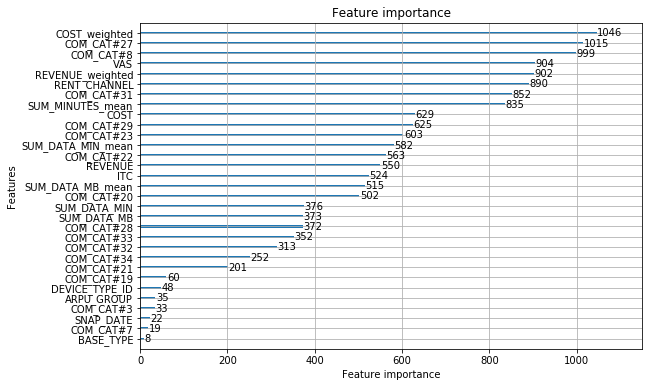

In [158]:
lgb.plot_importance(gbm, figsize=(9, 6))

### Submit

In [159]:
pred = gbm.predict_proba(test)[:, 1]
pd.DataFrame(pred).to_csv('submit.csv', header=False, index=False)
print(len(pred), np.where(pred > 0.5)[0])

5221 [  35   68   82  123  248  264  280  350  395  402  413  430  552  566
  673  835 1063 1119 1133 1179 1221 1326 1415 1447 1478 1598 1711 1741
 1805 1939 2133 2170 2433 2519 2676 2776 2809 2816 2821 2946 2954 2993
 3075 3245 3259 3340 3346 3457 3488 3622 3788 3900 3999 4185 4205 4347
 4362 4418 4545 4640 4792 5163 5170]
